In [7]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [8]:
now = datetime.datetime.now()

In [9]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [10]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

In [12]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=18)

# ＜RandomForest＞

In [13]:
%%time

rf_param = {
    'n_estimators': [i for i in range(1000,1300,100)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(3,10)],
    'min_samples_split': [i for i in range(2,16)],
    'random_state': [18],
    'verbose': [0]
}

rf = RandomForestClassifier()
gs_rf = GridSearchCV(rf, param_grid=rf_param, cv=skf, scoring='roc_auc', n_jobs=-1)
gs_rf.fit(x_train, y_train)

CPU times: user 24.4 s, sys: 3.5 s, total: 27.9 s
Wall time: 2h 34min 25s


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=18, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15],
                         'n_estimators': [1000, 1100, 1200],
                         'random_state': [18], 'verbose': [0]},
             scoring='roc_auc')

In [16]:
rf_best_param = gs_rf.best_params_

print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.8297325625282433
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 14, 'n_estimators': 1200, 'random_state': 18, 'verbose': 0}


In [17]:
rf_model = RandomForestClassifier(**rf_best_param, n_jobs=-1)
rf_model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=14,
                       n_estimators=1200, n_jobs=-1, random_state=18)

In [19]:
train_score_rf = rf_model.score(x_train, y_train)
test_score_rf = rf_model.score(x_test, y_test)

rf_p = rf_model.predict(x_test)

acc_rf = accuracy_score(rf_p, y_test)
auc_rf = roc_auc_score(rf_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_rf, test_score_rf))
print('acc:{}, auc:{}'.format(acc_rf, auc_rf))

train score:0.9320110701107011, test_score:0.9280442804428044
acc:0.9280442804428044, auc:0.8811119384462647


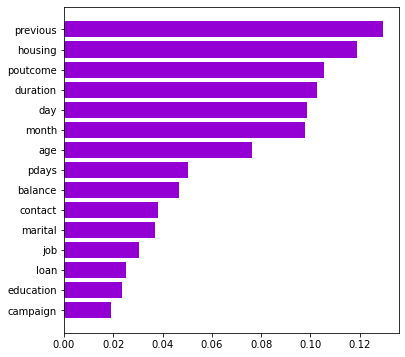

In [21]:
features = x_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='darkviolet', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [23]:
pred_rf = rf_model.predict_proba(test_df)
rf_p = pd.DataFrame(pred_rf)
rf_p.head()

,0,1
0,0.351893,0.648107
1,0.928926,0.071074
2,0.957092,0.042908
3,0.996419,0.003581
4,0.909486,0.090514


In [25]:
now = datetime.datetime.now()

rf_name = 'models/RF_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(rf_model, open(rf_name, 'wb'))

# ・SUBMIT

In [24]:
# RandomForest

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':rf_p[1]
})

file_name = 'submit/submit_RF' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)